In [1]:
import os
gpus = [0]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
import socket
import os
import sys
import pandas as pd
import scipy.io as sio
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import pylab
import h5py
import pickle
import seaborn as sns
import random
import collections
import logging
import datetime
import itertools
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import gc
import importlib
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sys.path.append("../..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *
from trainingfunctions import *

In [3]:
data_folder = os.path.abspath('/mnt/cube/kai/data_processed/bci/prelim_10_motif')
save_folder = os.path.abspath('/mnt/cube/kai/results/bci/prelim_10_motif')

# load data

In [4]:
input_output_df = pickle.load(open(os.path.join(data_folder, 'input_output_2021_04_23_06_38.p'), 'rb'))

In [5]:
input_output_df.tail()

,motif,step,input,output
1365,9,132,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[-0.34626780131000034, -0.6976743063570495, -0..."
1366,9,133,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.4414303893804583, -0.6573171533142144, -1...."
1367,9,134,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.45199486637298775, -0.6906773651003755, -0..."
1368,9,135,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.28211163644209253, -0.6644469578173456, -0..."
1369,9,136,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.2459257798562328, -0.7444524827126306, -0...."


In [6]:
n_motifs = len(input_output_df.motif.value_counts())
n_steps = len(input_output_df.step.value_counts())

In [7]:
n_lookbacks, n_clusters = input_output_df.input.values[0].shape

In [8]:
print(n_lookbacks, n_clusters)

10 73


In [9]:
n_specs = input_output_df.output.values[0].shape[0]

# model parameters

In [10]:
l2_val = 0.001
dropout_val = 0.2
num_neurons = [20, 30]

# training parameters

In [13]:
num_ep = 1000
patience = 50
early_stopping = True
valid_split = 0.1
batch_size = 10
n_parts = 5
mode = 'motif_wise'

# compile model

In [14]:
run_name = f'{datetime.datetime.now():%Y_%m_%d_%H_%M}'
run_folder = extend_folder(save_folder, run_name)
test_output_compiled = list()
test_prediction_compiled = list()
history_compiled = list()

for test_index in range(n_parts):
    index_folder = extend_folder(run_folder, str(test_index))
    train_input, train_output, test_input, test_output = train_test_split(input_output_df, n_parts, test_index, mode)
    
    # compile model
    model = Sequential()
    model.add(LSTM(num_neurons[0], input_shape = (n_lookbacks, n_clusters), return_sequences=True, 
                   kernel_regularizer=l2(l2_val)))
    model.add(Dropout(dropout_val))
    model.add(LSTM(num_neurons[1], kernel_regularizer=l2(l2_val)))
    model.add(Dropout(dropout_val))
    model.add(Dense(n_specs, kernel_regularizer=l2(l2_val)))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    model_file = os.path.join(index_folder, 'weights-improvement.h5')
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
                 ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)]
    history = model.fit(train_input, train_output, epochs=num_ep, batch_size=batch_size, verbose=1, 
                        validation_split=valid_split, callbacks=callbacks)
    
    # reload model to measure prediction loss
    del model
    model = load_model(model_file)
    
    # plot loss and validation loss over epochs
    fig = plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.savefig(os.path.join(index_folder, 'learning curve.png'))
    plt.close(fig)
    
    # test prediction, save to a pickle file
    test_prediction = model.predict(test_input)
    rmse = [np.sqrt(np.mean(np.square(np.array(prediction)-np.array(original)))) for prediction, original in zip(test_prediction, test_output)]
    save_file = os.path.join(index_folder,'results.p' )
    results_df = pd.DataFrame()
    results_df['prediction'] = list(test_prediction)
    results_df['target'] = list(test_output)
    results_df['rmse'] = rmse
    results_df.to_pickle(save_file)
    
    
    history_compiled.append([history.history['loss'], history.history['val_loss']])
    test_output_compiled+=list(test_output)
    test_prediction_compiled+=list(test_prediction)
    paragraph_print('Data appended', separation='-')

pickle.dump([test_output_compiled, 
             test_prediction_compiled, history_compiled], open(os.path.join(run_folder, 'all_results.p'), 'wb'))

Epoch 1/1000
99/99 [==============================] - 2s 19ms/step - loss: 0.3687 - val_loss: 0.1349
Epoch 2/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.1177 - val_loss: 0.0919
Epoch 3/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0827 - val_loss: 0.0717
Epoch 4/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0650 - val_loss: 0.0590
Epoch 5/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0529 - val_loss: 0.0482
Epoch 6/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0458 - val_loss: 0.0439
Epoch 7/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0401 - val_loss: 0.0411
Epoch 8/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0367 - val_loss: 0.0391
Epoch 9/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0350 - val_loss: 0.0374
Epoch 10/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0327 - val_lo

Epoch 82/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0187 - val_loss: 0.0355
Epoch 83/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0189 - val_loss: 0.0344
Epoch 84/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0185 - val_loss: 0.0338
Epoch 85/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0184 - val_loss: 0.0344
Epoch 86/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0184 - val_loss: 0.0351
Epoch 87/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0183 - val_loss: 0.0331
Epoch 88/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0182 - val_loss: 0.0324
Epoch 00088: early stopping
Data appended
--------------------------------------------------
Epoch 1/1000
99/99 [==============================] - 2s 18ms/step - loss: 0.3813 - val_loss: 0.1277
Epoch 2/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.1145 - val_loss: 

99/99 [==============================] - 1s 10ms/step - loss: 0.0198 - val_loss: 0.0308
Epoch 74/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0199 - val_loss: 0.0321
Epoch 75/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0200 - val_loss: 0.0294
Epoch 76/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0193 - val_loss: 0.0295
Epoch 77/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0193 - val_loss: 0.0325
Epoch 78/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0190 - val_loss: 0.0315
Epoch 79/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0201 - val_loss: 0.0312
Epoch 80/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0190 - val_loss: 0.0296
Epoch 81/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0190 - val_loss: 0.0322
Epoch 82/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0188 - val_loss: 0.0

99/99 [==============================] - 1s 10ms/step - loss: 0.0139 - val_loss: 0.0351
Epoch 154/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0341
Epoch 155/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0138 - val_loss: 0.0345
Epoch 156/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0136 - val_loss: 0.0338
Epoch 157/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0348
Epoch 158/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0138 - val_loss: 0.0340
Epoch 00158: early stopping
Data appended
--------------------------------------------------
Epoch 1/1000
99/99 [==============================] - 2s 19ms/step - loss: 0.3816 - val_loss: 0.1297
Epoch 2/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.1121 - val_loss: 0.0946
Epoch 3/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0794 - val_loss: 0.0700
E

Epoch 75/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0191 - val_loss: 0.0324
Epoch 76/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0192 - val_loss: 0.0344
Epoch 77/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0189 - val_loss: 0.0326
Epoch 78/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0192 - val_loss: 0.0334
Epoch 79/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0190 - val_loss: 0.0341
Epoch 80/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0190 - val_loss: 0.0342
Epoch 81/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0185 - val_loss: 0.0346
Epoch 82/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0188 - val_loss: 0.0354
Epoch 83/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0186 - val_loss: 0.0313
Epoch 84/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0188 - val_lo

Epoch 59/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0203 - val_loss: 0.0366
Epoch 60/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0201 - val_loss: 0.0374
Epoch 61/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0199 - val_loss: 0.0357
Epoch 62/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0198 - val_loss: 0.0370
Epoch 63/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0197 - val_loss: 0.0396
Epoch 64/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0193 - val_loss: 0.0395
Epoch 65/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0193 - val_loss: 0.0395
Epoch 66/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0190 - val_loss: 0.0371
Epoch 67/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0187 - val_loss: 0.0415
Epoch 68/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0184

99/99 [==============================] - 1s 10ms/step - loss: 0.0198 - val_loss: 0.0288
Epoch 61/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0192 - val_loss: 0.0313
Epoch 62/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0189 - val_loss: 0.0299
Epoch 63/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0186 - val_loss: 0.0320
Epoch 64/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0192 - val_loss: 0.0321
Epoch 65/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0181 - val_loss: 0.0327
Epoch 66/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0180 - val_loss: 0.0337
Epoch 67/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0183 - val_loss: 0.0245
Epoch 68/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0181 - val_loss: 0.0255
Epoch 69/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0178 - val_loss: 0

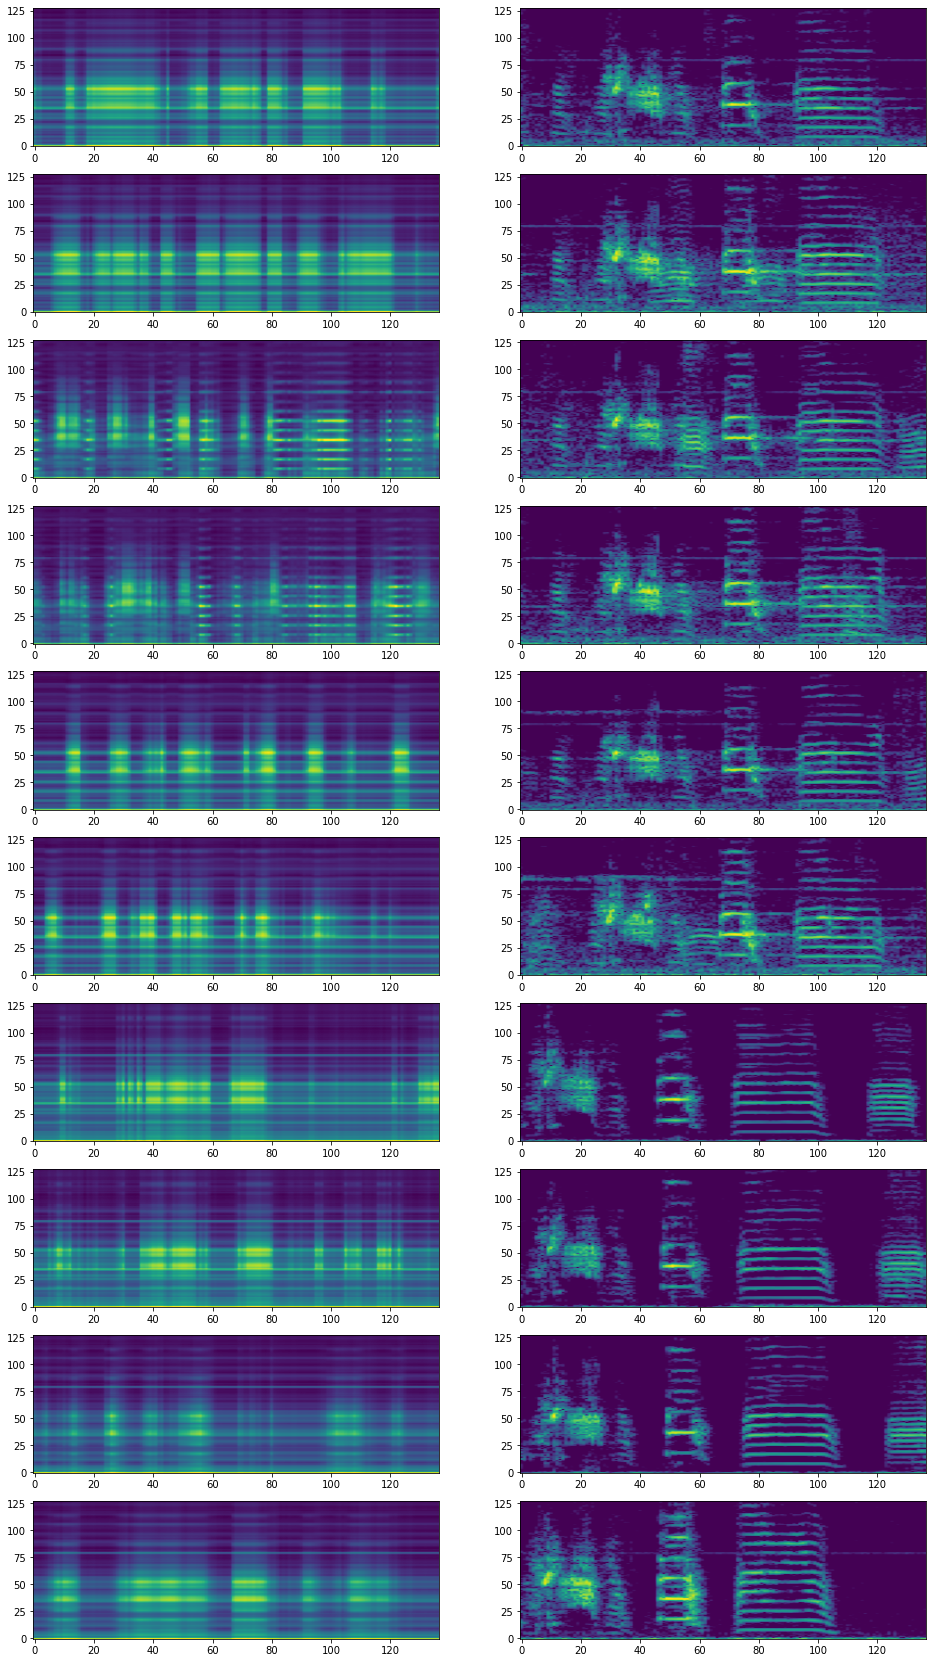

In [15]:
fig, ax = plt.subplots(10, 2, figsize=(16,30))
for i in range(n_motifs):
    ax[i][0].imshow(np.array(test_prediction_compiled[i*n_steps:(i+1)*n_steps]).T, origin='lower', aspect='auto')
    ax[i][1].imshow(np.array(test_output_compiled[i*n_steps:(i+1)*n_steps]).T, origin='lower', aspect='auto')